# Online Learning: Sentiment Analysis with Logistic Regression via Stochastic Gradient Ascent

This problem appeared as an assignment in the *coursera course* **Machine Learning - Classification**, part of *Machine Learning* specialization by the University of Washington. The following description of the problem is taken directly from the assignment. 

The goal of this assignment is to implement an *online logistic regression classifier* using *stochastic gradient ascent*. The following are the sub-tasks:

 * *Amazon product reviews* dataset is used along with positive / negative labels as the training dataset.
 * *Bag of words features*  will be extracted from the training dataset, only a pre-selected set of important words will be used as features.
 * The *partial derivative of log likelihood* (with *L2 penalty*) with respect to each single coefficient is computed.
 * *Stochastic gradient ascent* is implemented from sractch.
 * *Convergence* of *stochastic gradient ascent* is compared with that of *batch gradient ascent*.

In [131]:
#ipython nbconvert pcaiso.ipynb
%matplotlib inline

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
import pandas as pd

## Load and process review dataset

For this assignment, a subset of Amazon product review dataset is going to be used. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted of mostly positive reviews.

In [18]:
products = pd.read_csv('C:/courses/Coursera/Past/Specialization-UW Machine Learning/ML Classification/Week7/amazon_baby_subset.csv')
products['review'] = products.review.apply(str) #products['review'].astype(str)
products.head()
#products.dtypes

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


**Preprocessing**: We shall work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using string manipulation functionality.
2. Compute word counts (only for the important_words)

In [23]:
import json
with open('C:/courses/Coursera/Past/Specialization-UW Machine Learning/ML Classification/Week7/important_words.json', 'r') as f: 
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

# Remote punctuation
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

products = products.fillna({'review':''})  # fill in N/A's in the review column

products['review_clean'] = products['review'].apply(lambda x: remove_punctuation(x))

# Split out the words into individual columns
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

The data frame **products** now contains one column for each of the 193 **important_words**. 

In [25]:
products.head()
#products.shape

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


### Split data into training and validation sets

We will now split the data into a 90-10 split where 90% is in the training set and 10% is in the validation set. We use `seed=1` so that everyone gets the same result.

In [27]:
#train_data, validation_data = products.random_split(.9, seed=1)
train_data = products.sample(frac=0.9,random_state=1)
validation_data = products.drop(train_data.index)

print 'Training set  : %d data points' % len(train_data)
print 'Validation set: %d data points' % len(validation_data)

Training set  : 47765 data points
Validation set: 5307 data points


An additional colum '*intercept*' (filled with 1's) is needed to be inserted into the data frame to take account of the intercept term.

In [91]:
import numpy as np

def get_numpy_data(data_frame, features, label):
    data_frame['intercept'] = 1
    features = ['intercept'] + features
    #features_frame = data_frame[[features]]
    features_frame = pd.DataFrame(data_frame, columns=features)
    feature_matrix = features_frame.as_matrix()
    label_frame = pd.DataFrame(data_frame, columns=[label]) #data_frame[[label]]
    label_array = label_frame.as_matrix().flatten()
    return(feature_matrix, label_array)

Note that we convert both the training and validation sets into NumPy arrays.

**Warning**: This may take a few minutes.

In [121]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 
#print feature_matrix_valid, sentiment_valid
#print feature_matrix_valid.shape

C:\Users\Sandipan.Dey\Anaconda\envs\dato-env\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Building on logistic regression

Now the *link function* for **logistic regression** can be defined as:

$$
p(x_i)=P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))}=\frac{1}{1 + \exp(-\sum_j{w_j}h_j(x_i))},
$$

Log-likelihood $$\ell(\mathbf{w})=log \left(\prod_{i=1}^{N}{p(x_i)}^{y_i} {(1-p(x_i))}^{(1-y_i)}) \right)=\sum_{i=1}^{N}y_i.log(p(x_i))+(1-y_i).log(1-p(x_i))$$
$$=\sum_{i=1}^{N}y_i.log \left(\frac{p(x_i)}{1-p(x_i)} \right)+log(1-p(x_i))=\sum_{i=1}^{N}y_i.\mathbf{w}^T h(\mathbf{x}_i)) +log(1-p(x_i))$$

Hence, 
$$\ell(w_1,w_2,\ldots,w_j,\ldots)=\sum_{i=1}^{N}y_i.\mathbf{w}^T h(\mathbf{x}_i)-log(1+exp(\mathbf{w}^T h(\mathbf{x}_i)))=\sum_{i=1}^{N}y_i.\sum_j{w_j}h_j(x_i)-log \left(1+exp \left(\sum_j{w_j}h_j(x_i) \right)\right)$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. Now our goal is to maximize the log-likelihood function, which does not have a closed-form solution, hence techniques like *gradient descent* needs to be used.

The way the probability predictions are computed is not affected by using stochastic gradient ascent as a solver. Only the way in which the coefficients are learned is affected by using stochastic gradient ascent as a solver.

In [93]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1. / (1.+np.exp(-score))    
    return predictions

## Derivative of log likelihood with respect to a single coefficient

From the above expression for the *likelihood function* for *logistic regression*, it can be immediately shown that **the partial derivative of log likelihood with respect to a single coefficient** is as follows:

$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

This function to compute the derivative of log likelihood with respect to a single coefficient $w_j$ accepts the following two parameters:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$

In [98]:
def feature_derivative(errors, feature): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = sum(feature * errors)

    return derivative

**Note**. We are not using regularization in this assignment, but, stochastic gradient can also be used for regularized logistic regression, there will be one addtional term for regularization in the partial derivative.

To verify the correctness of the gradient computation, we use a function for computing average log likelihood (to be used for its numerical stability).

To track the performance of stochastic gradient ascent, we provide a function for computing **average log likelihood**. 

$$\ell\ell_A(\mathbf{w}) = \color{red}{\frac{1}{N}} \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$

**Note** that we made one tiny modification to the log likelihood function (called **compute_log_likelihood**) in our earlier assignments. We added a $\color{red}{1/N}$ term which averages the log likelihood accross all data points. The $\color{red}{1/N}$ term makes it easier for us to compare stochastic gradient ascent with batch gradient ascent. We will use this function to generate plots that are similar to those you saw in the lecture.

In [99]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):
    
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)
    
    return lp

In [100]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions        
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
#print "Gradient single data point: %s" % gradient_single_data_point
#print "           --> Should print 0.0"

## Modifying the partial derivative for using a batch of data points

Stochastic gradient estimates the ascent direction using 1 data point, while gradient uses $N$ data points to decide how to update the the parameters. A simple change that allows us to use a **mini-batch** of $B \leq N$ data points to estimate the ascent direction. This simple approach is faster than regular gradient but less noisy than stochastic gradient that uses only 1 data point. 

Given a mini-batch (or a set of data points) $\mathbf{x}_{i}, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$, the gradient function for this mini-batch of data points is given by:
$$
\color{red}{\sum_{s = i}^{i+B}} \frac{\partial\ell_{s}}{\partial w_j} = \color{red}{\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$

In [119]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

#print len(feature_matrix_train)

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions        
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
#print "Gradient mini-batch data points: %s" % gradient_mini_batch
#print "                --> Should print 1.0"

### Averaging the gradient across a batch

It is a common practice to normalize the gradient update rule by the batch size B:

$$
\frac{\partial\ell_{\color{red}{A}}(\mathbf{w})}{\partial w_j} \approx \color{red}{\frac{1}{B}} {\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$
In other words, we update the coefficients using the **average gradient over data points** (instead of using a summation). By using the average gradient, we ensure that the magnitude of the gradient is approximately the same for all batch sizes. This way, we can more easily compare various batch sizes of stochastic gradient ascent (including a batch size of **all the data points**), and study the effect of batch size on the algorithm as well as the choice of step size.


## Implementing stochastic gradient ascent

Now let's extend the algorithm for *batch gradient ascent* (that takes all the data at once) to *stochastic* (takes one data point at a time) and *mini-batch* gradient ascent (that takes data in small batches as input, computes the gradient and updates the coefficients). The following figure shows the gradient ascent algorithm, which needs to scaled dwon by appropriate batch size.

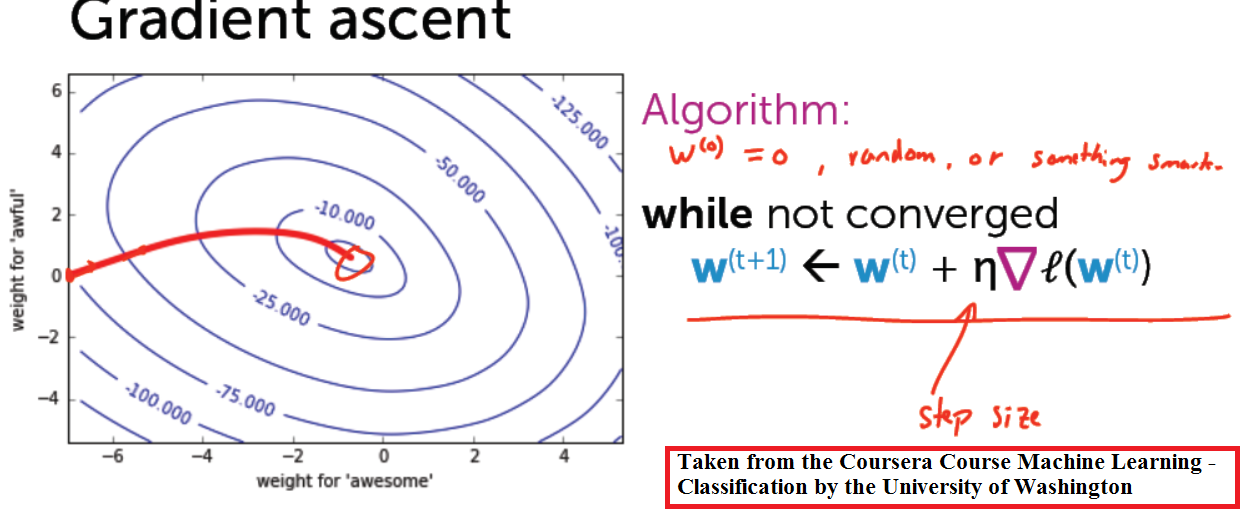

In [120]:
from IPython.display import Image
Image(filename='C:/courses/Coursera/Past/Specialization-UW Machine Learning/ML Classification/Week7/gd.png')

In [102]:
from math import sqrt
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []
    
    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]
    
    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        ### YOUR CODE HERE
        predictions = predict_probability(feature_matrix[i:i+batch_size,:], coefficients)
        
        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        ### YOUR CODE HERE
        indicator = (sentiment[i:i+batch_size]==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            ### YOUR CODE HERE
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size,j])

            # compute the product of the step size, the derivative, and the **normalization constant** (1./batch_size)
            ### YOUR CODE HERE
            coefficients[j] += step_size * derivative * (1./batch_size)
        
        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print 'Iteration %*d: Average log likelihood (of data points in batch [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp)
        
        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0
                
    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

**Note**. In practice, the final set of coefficients is rarely used; it is better to use the average of the last K sets of coefficients instead, where K should be adjusted depending on how fast the log likelihood oscillates around the optimum.

### Checkpoint


The following cell tests your stochastic gradient ascent function using a toy dataset consisting of two data points. If the test does not pass, make sure you are normalizing the gradient update rule correctly.

In [123]:
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3),
                                                  step_size=1., batch_size=2, max_iter=2)
print '-------------------------------------------------------------------------------------'
print 'Coefficients learned                 :', coefficients
print 'Average log likelihood per-iteration :', log_likelihood
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print '-------------------------------------------------------------------------------------'
    print 'Test passed!'
else:
    print '-------------------------------------------------------------------------------------'
    print 'Test failed'

Iteration 0: Average log likelihood (of data points in batch [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points in batch [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


## Compare convergence behavior of stochastic gradient ascent

For the remainder of the assignment, let's compare *stochastic gradient ascent* against *batch gradient ascent*. For this, we need a reference implementation of batch gradient ascent. 

## Running gradient ascent using the stochastic gradient ascent implementation

Let's now **run stochastic gradient ascent** over the **feature_matrix_train** for 10 iterations using:
* `initial_coefficients = zeros`
* `step_size = 5e-1`
* `batch_size = 1`
* `max_iter = 10`

In [125]:
coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=1, max_iter=10)

Iteration 0: Average log likelihood (of data points in batch [00000:00001]) = -0.01416346
Iteration 1: Average log likelihood (of data points in batch [00001:00002]) = -0.00505439
Iteration 2: Average log likelihood (of data points in batch [00002:00003]) = -0.00177457
Iteration 3: Average log likelihood (of data points in batch [00003:00004]) = -0.00311449
Iteration 4: Average log likelihood (of data points in batch [00004:00005]) = -0.06140707
Iteration 5: Average log likelihood (of data points in batch [00005:00006]) = -0.00000011
Iteration 6: Average log likelihood (of data points in batch [00006:00007]) = -0.02461738
Iteration 7: Average log likelihood (of data points in batch [00007:00008]) = -0.00876472
Iteration 8: Average log likelihood (of data points in batch [00008:00009]) = -0.00003921
Iteration 9: Average log likelihood (of data points in batch [00009:00010]) = -0.00000620


As expected, as each iteration passes, how does the average log likelihood in the batch fluctuates with *stochastic gradient descent* (i.e., with batch size 1).

Now let's again run **batch gradient ascent** over the **feature_matrix_train** but this time for 200 iterations using:

* `initial_coefficients = zeros`
* `step_size = 5e-1`
* `batch_size = # data points in the training dataset`
* `max_iter = 200`

In [105]:
# YOUR CODE HERE
coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=len(feature_matrix_train), max_iter=200)

Iteration   0: Average log likelihood (of data points in batch [00000:47765]) = -0.68313840
Iteration   1: Average log likelihood (of data points in batch [00000:47765]) = -0.67402166
Iteration   2: Average log likelihood (of data points in batch [00000:47765]) = -0.66563558
Iteration   3: Average log likelihood (of data points in batch [00000:47765]) = -0.65788618
Iteration   4: Average log likelihood (of data points in batch [00000:47765]) = -0.65070149
Iteration   5: Average log likelihood (of data points in batch [00000:47765]) = -0.64402111
Iteration   6: Average log likelihood (of data points in batch [00000:47765]) = -0.63779295
Iteration   7: Average log likelihood (of data points in batch [00000:47765]) = -0.63197173
Iteration   8: Average log likelihood (of data points in batch [00000:47765]) = -0.62651787
Iteration   9: Average log likelihood (of data points in batch [00000:47765]) = -0.62139668
Iteration  10: Average log likelihood (of data points in batch [00000:47765]) = 

As expected, with (full) batch gradient ascent, as each iteration passes, the average log likelihood in the batch continuously increases.

## Make "passes" over the dataset

To make a fair comparison betweeen stochastic gradient ascent and batch gradient ascent, we measure the average log likelihood as a function of the number of passes (defined as follows):
$$
[\text{# of passes}] = \frac{[\text{# of data points touched so far}]}{[\text{size of dataset}]}
$$

## Log likelihood plots for stochastic gradient ascent

With the terminology in mind, let us run stochastic gradient ascent for 10 passes. We will use
* `step_size=1e-1`
* `batch_size=100`
* `initial_coefficients` to all zeros.

In [114]:
step_size = 1e-1
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68197844
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.68360557
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.67672535
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.68262376
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67601418
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67149018
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.67302292
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67288246
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.67104021
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.66754591
Iteration   10: Average log likelihood (of data points in batch [01000

Let's plot the average log likelihood as a function of the number of passes.

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')
    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

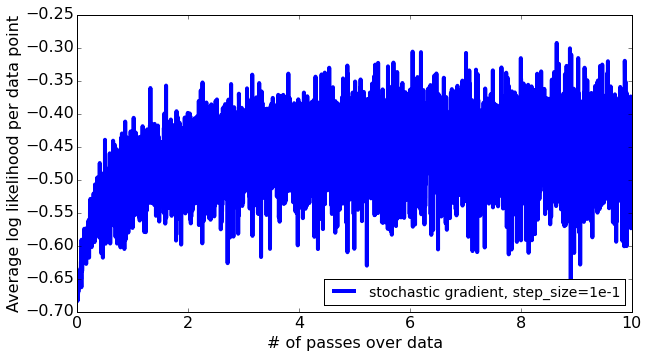

In [116]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          label='stochastic gradient, step_size=1e-1')

## Smoothing the stochastic gradient ascent curve

The plotted line oscillates so much that it is hard to see whether the log likelihood is improving. In our plot, we apply a simple smoothing operation using the parameter `smoothing_window`. The smoothing is simply a [moving average](https://en.wikipedia.org/wiki/Moving_average) of log likelihood over the last `smoothing_window` "iterations" of  stochastic gradient ascent.

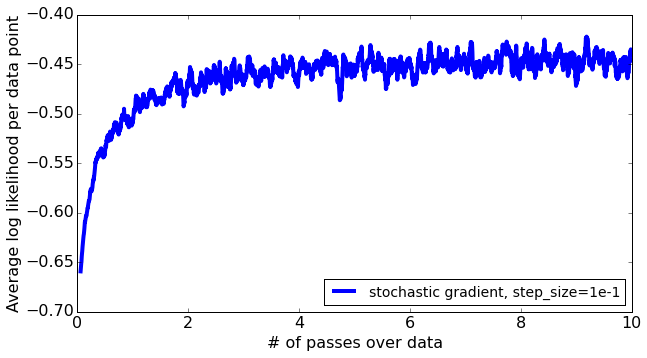

In [117]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')

## Stochastic gradient ascent vs batch gradient ascent

To compare convergence rates for stochastic gradient ascent with batch gradient ascent, let's plot the change in log-likelihood with the iterations.

We are comparing:
* **stochastic gradient ascent**: `step_size = 0.1`, `batch_size=100`
* **batch gradient ascent**: `step_size = 0.5`, `batch_size= # data points`

Write code to run stochastic gradient ascent for 200 passes using:
* `step_size=1e-1`
* `batch_size=100`
* `initial_coefficients` to all zeros.

In [126]:
step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

## YOUR CODE HERE
coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration     0: Average log likelihood (of data points in batch [00000:00100]) = -0.68197844
Iteration     1: Average log likelihood (of data points in batch [00100:00200]) = -0.68360557
Iteration     2: Average log likelihood (of data points in batch [00200:00300]) = -0.67672535
Iteration     3: Average log likelihood (of data points in batch [00300:00400]) = -0.68262376
Iteration     4: Average log likelihood (of data points in batch [00400:00500]) = -0.67601418
Iteration     5: Average log likelihood (of data points in batch [00500:00600]) = -0.67149018
Iteration     6: Average log likelihood (of data points in batch [00600:00700]) = -0.67302292
Iteration     7: Average log likelihood (of data points in batch [00700:00800]) = -0.67288246
Iteration     8: Average log likelihood (of data points in batch [00800:00900]) = -0.67104021
Iteration     9: Average log likelihood (of data points in batch [00900:01000]) = -0.66754591
Iteration    10: Average log likelihood (of data points in b

We compare the convergence of stochastic gradient ascent and batch gradient ascent in the following cell. Note that we apply smoothing with `smoothing_window=30`.

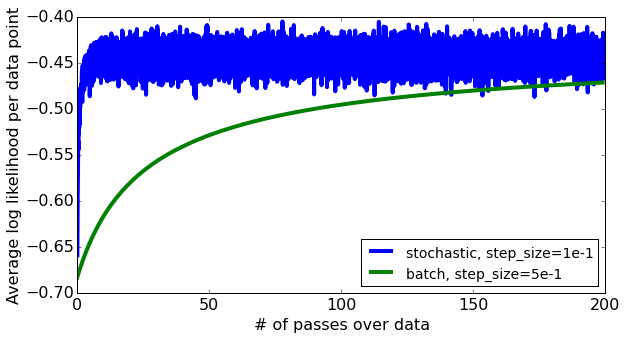

In [127]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic, step_size=1e-1')
make_plot(log_likelihood_batch, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=1, label='batch, step_size=5e-1')

As can be seen from the figure above, the batch gradient ascent needs at least 150 passes to achieve a similar log likelihood as stochastic gradient ascent.

## Explore the effects of step sizes (learning rate) on stochastic gradient ascent

To start, let's explore a wide range of step sizes that are equally spaced in the log space and run *stochastic gradient ascent* with `step_size` set to 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, and 1e2, using the following set of parameters:

* `initial_coefficients=zeros`
* `batch_size=100`
* `max_iter` initialized so as to run 10 passes over the data.

In [128]:
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.69313572
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.69313813
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.69312970
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.69313664
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.69312912
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.69312352
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.69312565
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.69312596
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.69312480
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.69311820
Iteration   10: Average log likelihood (of data points in batch [01000

### Plotting the log likelihood as a function of passes for each step size

Now, let's plot the change in log likelihood for each of the following values of `step_size`:

* `step_size = 1e-4`
* `step_size = 1e-3`
* `step_size = 1e-2`
* `step_size = 1e-1`
* `step_size = 1e0`
* `step_size = 1e1`
* `step_size = 1e2`

For consistency, we again apply `smoothing_window=30`.

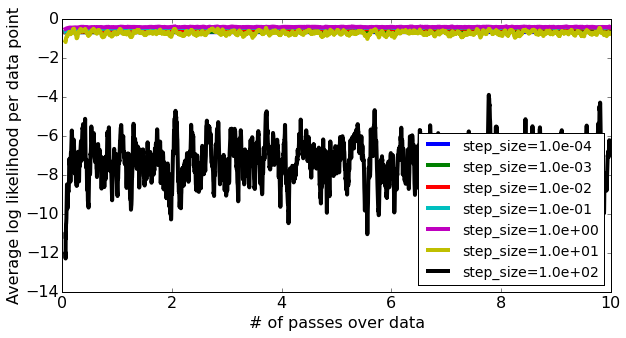

In [129]:
for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

Now, let us remove the step size `step_size = 1e2` and plot the rest of the curves.

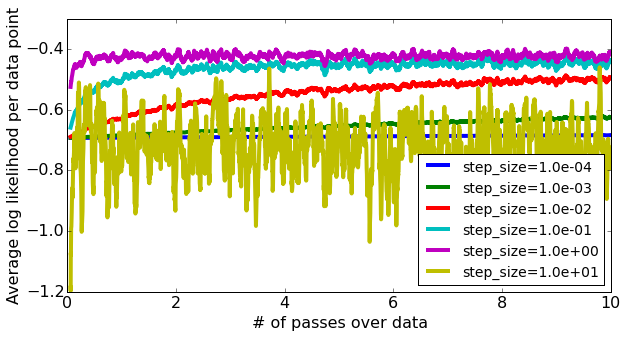

In [130]:
for step_size in np.logspace(-4, 2, num=7)[0:6]:
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

As can be seen from the above plots, the step size 1e2 gives the worst result and step size 1 and 0.1 gives the best results in terms of convergence.